# Chapter 7 - Unsupervised Learning

Import required Python packages

In [88]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

Path set:

In [86]:
SP500_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\sp500_data.csv"
SP500_SECTORS_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\sp500_sectors.csv"
LOAN_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan_data.csv"
HOUSE_TASKS_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\housetasks.csv"


# Principal Component Analysis

# A Simple Example
In _Python_, we can use the scikit-learn implementation `sklearn.decomposition.PCA`:

In [49]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [50]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0  0.664711  0.747101
1  0.747101 -0.664711


It is instructive to plot the principal components with the data. Here we create a visualization in _Python_:

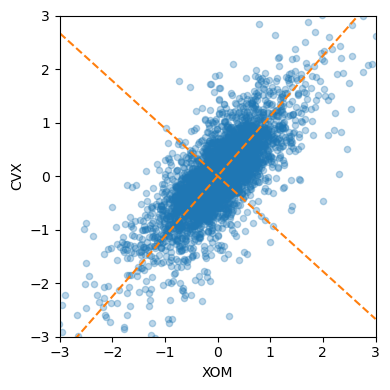

In [52]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return(x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4,4))
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax), 
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax), 
        '--', color='C1')


plt.tight_layout()
plt.show()

# Interpreting Principal Components

The following codes shows an example for a few top companies in the S&P 500. The information to create a loading plot from `scikit-learn` results is available in `explained_variance_`. Here, we convert it into a pandas data frame and use it to make a bar chart:

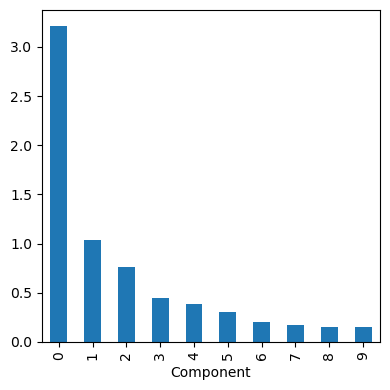

In [54]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
              'JPM', 'WFC', 'USB','AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

It can be especially revealing to plot the weights of the top principal components. Here is the code to create visualization in _Python_.

In [56]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0  0.300825  0.246332  0.261529  0.273634  0.064059  0.444490  0.207983   
1  0.505116  0.139426 -0.174212  0.416307  0.031939 -0.289373  0.278002   
2  0.786730 -0.135458  0.002367 -0.465862  0.007524 -0.082374 -0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4 -0.111576  0.596666  0.005813 -0.555529  0.039860 -0.109016  0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0  0.076956  0.196397  0.105012  0.481786  0.148833  0.116421  0.145684   
1  0.033898  0.040723  0.053954 -0.472494  0.228123  0.054796  0.047427   
2  0.003518 -0.062261 -0.016248  0.194822 -0.160833 -0.048976 -0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4  0.072047  0.385160  0.077135 -0.181332  0.055557  0.155440  0.216425   

        WMT       XOM  
0  0.122304  0.317952  
1  0.222889 -0.154192  
2 -0.175806 -0.090167  
3 

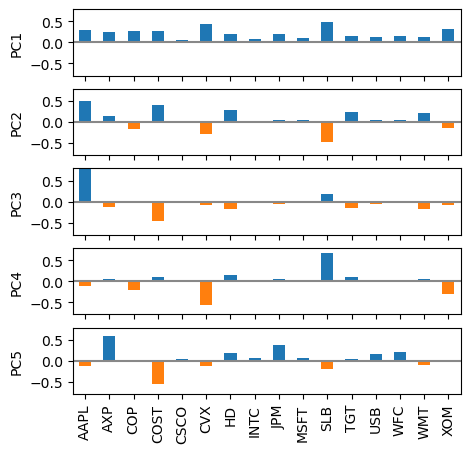

In [57]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))

f, axes = plt.subplots(5, 1, figsize=(5,5), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

# Correspondence Analysis

In _Python_, we can use the `prince` package, which implements correspondence analysis using the `scikit-lean` API:

In [60]:
from adjustText import adjust_text

ModuleNotFoundError: No module named 'adjustText'

In [ ]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()
plt.show()

# K-Means Clustering

# A Simple Example

We use the `sklearn.cluster.KMeans` method from scikit-learn in _Python_:

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4, n_init='auto').fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

In `scikit-learn`, the cluster _centers_ are available in the `cluster_centers_field`:

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

In this example, with just two variables, it is straightforward to visualize the clusters and their means. The seaborn scatterplot function makes it easy to color (`hue`) and style (`style`) the points by a property:

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster',
                    ax=ax, data=df)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

The resulting plot shows the cluster assignments and the cluster means. Note that K-means will assign records to clusters, even if those clusters are not well separated (which can be useful if you need to optimally divide records into groups).

# K-Means Algorithm

The scikit-learn algorithm is repeated 10 by default (n_init). The argument max_iter (default 300) can be used to control the number of iterations:

In [ ]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5, n_init='auto').fit(top_sp)

# Interpreting the Clusters

The 2 most important outputs from kmeans are the _sizes_ of the clusters and the cluster _means_. In _Python_, we can use the `collections.Counter` class from the standard library to get this information. Due to the differences in the implementation and the inherent randomness of the algorithm, results will vary:

In [92]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({3: 13023, 0: 7906, 1: 1654, 2: 88})


You can plot the centers of the clusters using this code in _Python_ and it is similar to waht we used for PCA:

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

# Selecting the Number of Clusters

For the KMeans result, we get this information from the property `inertia_`. After conversion into a pandas data frame, we can use its plot method to create the graph:

In [ ]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Square Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Hierarchical Clustering

# A Simple Example

Clustering algorithms will cluster the records (rows) of a data frame. Since we want to cluster the companies, we need to _transpose_ (t) the data frame and put the stocks along the rows and the dates along the columns.

The scipy package offers a number of different methods for hierarchical clustering the `scipy.cluster.hierarchy` module. Here we use the linkage function with the "complete" method:

In [ ]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 
         'GOOGL', 'HD', 'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 
         'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

# The Dendrogram

We can use the `dendogram` method to plot the result of the linkage function in _Python_:

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
dendrogram(Z, labels = list(df.index), ax=ax, color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

You can identify different number of clusters with a horizontal line that slides up or down; a cluster is defined wherever the horizontal line intersects the vertical lines. To extract a specific number of clusters, you can use the `fcluster` method:

In [ ]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)

for key, item in memb.groupby(memb):
    print(f"{key}: {','.join(item.index)}")

# Measures of Dissimilarity

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5,5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster (Z, 4, criterion='maxclust')]
    ax= sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                       size=0.5, ax=ax, data=df, legend=False)
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

# Model Based Clustering

# Multivariate Normal Distribution

In [ ]:
mean = [0.5, -0.5]
cov = [[1,1], [1,2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1-p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)

CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')

plt.tight_layout()
plt.show()

# Mixture of Normals

`scikit-learn` has the sklearn.mixture.GaussianMixture class for model-based clustering:

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

Here is the _Python_ code to create a similar figure:

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

plt.tight_layout()
plt.show()

You can extract the parameters to the normal distribution using the `means_` and `covariances_` properties of the result:

In [ ]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

# Selecting the Number of Clusters

In [ ]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components,
                                warm_start=True, 
                                 covariance_type=covariance_type) #warm_start argument, the calculation will resuse information from the previous fit. This will speed up the convergence of subsequent calculaitons.
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })

results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-', 'C1:', 'C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4,4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type,
               kind='line', style=styles[i])

plt.tight_layout()
plt.show()

# Scaling and Categorical Variables

# Scaling the Variables

In [94]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                     categories=['paid off', 'default'],
                                     ordered=True)

defaults = loan_data.loc[loan_data['outcome'] == 'default',]
columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc',
          'dti', 'revol_util']
df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  17809.760881   78669.452556  18933.405997  11.594003  17.016428   
1  21444.318867  148736.057263  33152.689572  12.376733  13.831145   
2  24290.909091  409746.465909  84710.988636  13.431818   8.148636   
3  10274.160906   41241.205530   9950.095008   9.480338  17.718588   

   revol_util   size  
0   62.183810   7906  
1   63.151084   1654  
2   60.015647     88  
3   57.903425  13023  


In _Python_, we can use `scikit-learn`'s StandardScaler. The `inverse_transform` method allows converting the cluster centers backt to the original scale:

In [96]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 10)

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

       loan_amnt    annual_inc      revol_bal    open_acc         dti  \
0  134847.289060  5.590799e+05  164358.033365  143.222650  242.115351   
1  259502.051422  1.168341e+06  329459.729212  123.963348  161.659136   
2  105072.830927  5.111799e+05  116352.852517   75.095129  159.315612   
3  103248.463687  5.345682e+05   60548.199255   86.646182  113.129832   

   revol_util  size  
0  594.636076  6244  
1  661.235423  3670  
2  777.950774  7397  
3  309.998745  5360  


# Dominant Variables

Text(0.5, 0, 'Component')

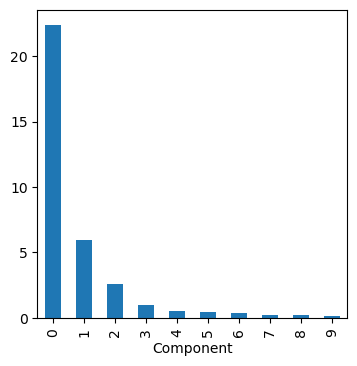

In [100]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]
sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')

In [102]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL  0.857310 -0.477873
AMZN   0.444728  0.874149
AAPL   0.071627  0.020802
MSFT   0.036002  0.006204
CSCO   0.029205  0.003045
INTC   0.026666  0.006069
CVX    0.089548  0.037420
XOM    0.080336  0.020511
SLB    0.110218  0.030356
COP    0.057739  0.024117
JPM    0.071228  0.009244
WFC    0.053228  0.008597
USB    0.041670  0.005952
AXP    0.078907  0.024027
WMT    0.040346  0.007141
TGT    0.063659  0.024662
HD     0.051412  0.032922
COST   0.071403  0.033826


# Categorical Data and Gower's Distance

In [104]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


# Problems with Clustering Mixed Data

In [109]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  21.431365          12.354001      0.943315    1.243450e-14 -1.401657e-15   
1  12.743276           5.918701      0.900372    1.304512e-14 -3.330669e-16   
2  17.339786           8.353535      0.905716    1.000000e+00  2.969847e-15   
3  17.197993           9.266666      0.917903   -2.331468e-15  1.000000e+00   

     home__RENT  
0  1.000000e+00  
1  1.000000e+00  
2  9.603429e-15  
3 -2.220446e-15  
